In [47]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import matplotlib.pyplot as plt
%matplotlib inline
import unidecode
import hiplot as hip
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from feature_engine.encoding import RareLabelEncoder
from sklearn.metrics import make_scorer
import sys
import os

In [2]:
cd ../

/Users/arjunsingh/Machine Learning/price_prediction


In [3]:
# Reading the data and dropping the extra column drug_id
columns_to_skip = 'drug_id'
df_train_data = pd.read_csv('data/raw/drugs_train.csv',usecols=lambda x: x not in columns_to_skip)
df_test_data = pd.read_csv('data/raw/drugs_test.csv',usecols=lambda x: x not in columns_to_skip)
df_features = pd.read_csv('data/raw/drug_label_feature_eng.csv')

In [4]:
#Duplicate data
df_train_data[df_train_data.duplicated(keep=False)==True].sort_values(by=['description'])

description administrative_status  \
7476  1 flacon(s) compte-gouttes polyéthylène de 10  ml   Présentation active   
4737  1 flacon(s) compte-gouttes polyéthylène de 10  ml   Présentation active   
5846  1 flacon(s) en verre brun de 150 ml avec gobel...   Présentation active   
7269  1 flacon(s) en verre brun de 150 ml avec gobel...   Présentation active   
6880  1 flacon(s) en verre de 1,55 ml avec pompe(s) ...   Présentation active   
...                                                 ...                   ...   
5644  plaquette(s) thermoformée(s) polyamide alumini...   Présentation active   
5555  plaquette(s) thermoformée(s) polyamide alumini...   Présentation active   
3164  plaquette(s) thermoformée(s) polyamide alumini...   Présentation active   
2812  plaquette(s) thermoformée(s) polychlortrifluor...   Présentation active   
5065  plaquette(s) thermoformée(s) polychlortrifluor...   Présentation active   

     approved_for_hospital_use reimbursement_rate  marketing_declaration_date  \
7476                       oui                65%                    19930101   
4737                       oui                65%                    19930101   
5846                       oui                15%                    20100101   
7269                       oui                15%                    20100101   
6880                       oui                65%                    20110101   
...                        ...                ...                         ...   
5644                       oui                65%                    20140101   
5555                       oui                65%                    20140101   
3164                       oui                65%                    20140101   
2812                       oui                65%                    20110101   
5065                       oui                65%                    20110101   

      marketing_authorization_date       marketing_authorization_process  \
7476                      19880101                   Procédure nationale   
4737                      19880101                   Procédure nationale   
5846                      20100101                   Procédure nationale   
7269                      20100101                   Procédure nationale   
6880                      20100101                 Procédure centralisée   
...                            ...                                   ...   
5644                      20140101               Procédure décentralisée   
5555                      20140101               Procédure décentralisée   
3164                      20140101               Procédure décentralisée   
2812                      20050101  Procédure de reconnaissance mutuelle   
5065                      20050101  Procédure de reconnaissance mutuelle   

                    pharmaceutical_companies   price  
7476                                   ALCON    1.58  
4737                                   ALCON    1.58  
5846                                BIOGARAN    1.84  
7269                                BIOGARAN    1.84  
6880    ARCHIMEDES DEVELOPMENT (ROYAUME-UNI)   58.42  
...                                      ...     ...  
5644                 LABORATOIRES GRUNENTHAL  185.74  
5555                 LABORATOIRES GRUNENTHAL  185.74  
3164                 LABORATOIRES GRUNENTHAL  185.74  
2812   MERCK SHARP & DOHME (GRANDE BRETAGNE)  138.85  
5065   MERCK SHARP & DOHME (GRANDE BRETAGNE)  138.85  

[1200 rows x 9 columns]

### Data preprocessing and Mapping features from feature file

In [5]:
# Dropping duplicate data and doing a bit of cleaning
def fix_duplicates(df):
    df['description'] = df['description'].map(lambda x: re.sub('  ',' ',x))
    df['description'] = df['description'].map(lambda x: x[1:-1] if x.startswith('"') and x.endswith('"')else x)
    if 'pharmaceutical_companies' in df.columns:
        df['pharmaceutical_companies'] = df['pharmaceutical_companies'].map(lambda x: x[1:-1] if x.startswith('"') or x.endswith('"')else x)
        df['pharmaceutical_companies'] = df['pharmaceutical_companies'].map(lambda x: x[1:-1] if x.startswith(' ') or x.endswith(' ')else x)
    df = df.drop_duplicates(keep='first').reset_index(drop=True)
    return df

In [6]:
# Converting date columns to datetime and to year
def date_features(df):
    # We could convert the date to datetime but we will use year as month and date are both 01, 01 e.g. 2014-01-01
    df['marketing_declaration_date'] = pd.to_datetime(df['marketing_declaration_date'], format='%Y%m%d').dt.year
    df['marketing_authorization_date'] = pd.to_datetime(df['marketing_authorization_date'], format='%Y%m%d').dt.year
    return df

In [7]:
#Mapping Features from feature file and the logic developed to do it automatically
def fix_missing_label_count_values_file(df,features):
    #It takes the dataframe of the labels and the dataframe of the features and merges them together
    #:return: The dataframe with the missing values filled in.
    # fixing features from CSV file, in our case its default functionality
    return df.merge(features, how='left', on='description')

def fix_missing_label_count_values_logic(df):
    # fixing features using logic, secondary case when we still have missing values after merging with features file
    # Logic: check for the column labels in the feature file and search for them in the description, 
    # if found then add the label 0 -1 and correspondingly find the count in the description as well
    #The function takes in a dataframe and returns a dataframe with missing values in the label_ and
    #count_ features filled in using the manual search logic
    #:return: The dataframe with the missing values filled in.
    
    test = df[[col for col in df.columns if 'label_' in col or 'count_' in col]]
    label_items = [re.sub('label_', '',l)for l in test if 'label_' in l]
    count_items = [re.sub('count_', '',l)for l in test if 'count_' in l]
    new_value_dictionary = dict()
    # Fixing missing values in label_ features in the training data
    for idx, text in df.loc[df['label_plaquette'].isna(),'description'].iteritems():
        #li1 = []
        #print(idx)
        for item in label_items:
            if item in text:
                #li1.append({'label_'+item:1})
                new_value_dictionary['label_'+item] = 1
            else:
                #li1.append({'label_'+item:0})
                new_value_dictionary['label_'+item] = 0
        #print(dic)   
    
    # Fixing missing values in counts_ features in the training data
    #for text in df.loc[df['count_plaquette'].isna(),'description']:
        #li = []
        text = unidecode.unidecode(text)
        list_of_words = text.split()
        #print([re.sub(r'\([s)]*\)','', word) for word in list_of_words])
        sentence = [re.sub(r'\([s)]*\)','', word) for word in list_of_words]
        for word in count_items:
            if word in sentence:
                ind = sentence.index(word)
                if ind == 0:
                    #li.append({'count_'+word:0})
                    new_value_dictionary['count_'+word] = 0
                else:
                    try:
                        #if sentence[ind-1].isdigit() == True:
                        #li.append({'count_'+word:int(sentence[ind-1])})
                        new_value_dictionary['count_'+word] = int(sentence[ind-1])
                    except:
                        #li.append({'count_'+word:0})
                        new_value_dictionary['count_'+word] = 0
            else:
                #li.append({'count_'+word:0})
                new_value_dictionary['count_'+word] = 0
        #print(li1+li)
        #print(new_value_dictionary)
        for key in new_value_dictionary.keys():
            df.loc[idx,key] = new_value_dictionary.get(key)
            #print(df.loc[idx,key])
    return df

def fix_missing_label_count(df,features):
    # Fix features from CSV file
    # it does two thing firstly it tries to map the features in the features.csv file to traning data 
    # and then for those records where feature is missing we run the the logic to fill those values
    df = fix_missing_label_count_values_file(df, features)
    # check if we still have missing value for those features added from file and fix them with logic
    if df[df['label_plaquette'].isna()]['description'].nunique() != 0:
        df = fix_missing_label_count_values_logic(df.copy())
    return df

In [8]:
df_features = fix_duplicates(df_features)

In [9]:
df_train = fix_duplicates(df_train_data)
df_train = date_features(df_train)
df_train = fix_missing_label_count(df_train,df_features)

In [10]:
##This is the troublesome part of the code.
##we have records where the entire record is same except the price of the drug.
df_train[df_train.duplicated(keep=False,subset=df_train.columns.difference(['price']))==True].sort_values(by=['description']).head(6)

description administrative_status  \
5844                      1 ampoule(s) en verre de 2 ml   Présentation active   
4617                      1 ampoule(s) en verre de 2 ml   Présentation active   
7343  1 bouteille(s) polypropylène de 100 ml avec se...   Présentation active   
2205  1 bouteille(s) polypropylène de 100 ml avec se...   Présentation active   
5834             1 bouteille(s) polypropylène de 150 ml   Présentation active   
6293             1 bouteille(s) polypropylène de 150 ml   Présentation active   

     approved_for_hospital_use reimbursement_rate  marketing_declaration_date  \
5844                       oui                65%                        2012   
4617                       oui                65%                        2012   
7343                       oui                65%                        2013   
2205                       oui                65%                        2013   
5834                       oui                65%                        2007   
6293                       oui                65%                        2007   

      marketing_authorization_date marketing_authorization_process  \
5844                          1984             Procédure nationale   
4617                          1984             Procédure nationale   
7343                          1995             Procédure nationale   
2205                          1995             Procédure nationale   
5834                          1995             Procédure nationale   
6293                          1995             Procédure nationale   

     pharmaceutical_companies  price  label_plaquette  ...  count_stylo  \
5844                 PANPHARM   1.21              0.0  ...          0.0   
4617                 PANPHARM   2.68              0.0  ...          0.0   
7343             GE HEALTHCAR  33.64              0.0  ...          0.0   
2205             GE HEALTHCAR  39.23              0.0  ...          0.0   
5834             GE HEALTHCAR  57.10              0.0  ...          0.0   
6293             GE HEALTHCAR  48.73              0.0  ...          0.0   

      count_seringue  count_pilulier  count_sachet  count_comprime  \
5844             0.0             0.0           0.0             0.0   
4617             0.0             0.0           0.0             0.0   
7343             0.0             0.0           0.0             0.0   
2205             0.0             0.0           0.0             0.0   
5834             0.0             0.0           0.0             0.0   
6293             0.0             0.0           0.0             0.0   

      count_gelule  count_film  count_poche  count_capsule  count_ml  
5844           0.0         0.0          0.0            0.0       2.0  
4617           0.0         0.0          0.0            0.0       2.0  
7343           0.0         0.0          0.0            0.0     100.0  
2205           0.0         0.0          0.0            0.0     100.0  
5834           0.0         0.0          0.0            0.0     150.0  
6293           0.0         0.0          0.0            0.0     150.0  

[6 rows x 36 columns]

In [11]:
df_train.loc[[5844,4617],'description']

5844    1 ampoule(s) en verre de 2 ml
4617    1 ampoule(s) en verre de 2 ml
Name: description, dtype: object

It seems that minimum price is larger than zero. Excellent! We don't have one of those personal traits that would destroy my model!

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


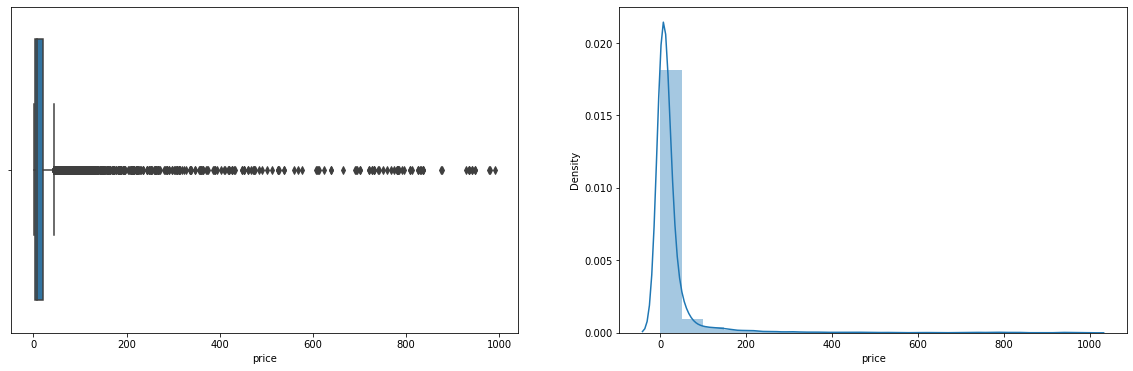

In [12]:
#histogram
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
sns.boxplot(df_train['price'])
plt.subplot(1,2,2)
sns.distplot(df_train['price'],bins=20)
plt.show()

In [13]:
df_train.select_dtypes(['float64','int64']).describe().round(2)

marketing_declaration_date  marketing_authorization_date    price  \
count                     7877.00                       7877.00  7877.00   
mean                      2006.22                       2003.12    29.16   
std                         10.68                          8.29    83.80   
min                       1910.00                       1973.00     0.60   
25%                       2004.00                       1998.00     3.77   
50%                       2010.00                       2006.00     7.73   
75%                       2013.00                       2009.00    19.77   
max                       2016.00                       2015.00   990.39   

       label_plaquette  label_ampoule  label_flacon  label_tube  label_stylo  \
count          7877.00        7877.00       7877.00     7877.00      7877.00   
mean              0.69           0.02          0.15        0.03         0.01   
std               0.46           0.15          0.36        0.17         0.08   
min               0.00           0.00          0.00        0.00         0.00   
25%               0.00           0.00          0.00        0.00         0.00   
50%               1.00           0.00          0.00        0.00         0.00   
75%               1.00           0.00          0.00        0.00         0.00   
max               1.00           1.00          1.00        1.00         1.00   

       label_seringue  label_pilulier  ...  count_stylo  count_seringue  \
count         7877.00         7877.00  ...      7877.00         7877.00   
mean             0.05            0.01  ...         0.00            0.10   
std              0.23            0.12  ...         0.08            0.84   
min              0.00            0.00  ...         0.00            0.00   
25%              0.00            0.00  ...         0.00            0.00   
50%              0.00            0.00  ...         0.00            0.00   
75%              0.00            0.00  ...         0.00            0.00   
max              1.00            1.00  ...         5.00           28.00   

       count_pilulier  count_sachet  count_comprime  count_gelule  count_film  \
count         7877.00       7877.00          7877.0       7877.00     7877.00   
mean             0.01          0.48            25.2          4.81        0.00   
std              0.11          4.01            33.3         16.98        0.05   
min              0.00          0.00             0.0          0.00        0.00   
25%              0.00          0.00             0.0          0.00        0.00   
50%              0.00          0.00            15.0          0.00        0.00   
75%              0.00          0.00            30.0          0.00        0.00   
max              3.00        120.00           480.0        360.00        2.00   

       count_poche  count_capsule  count_ml  
count      7877.00        7877.00   7877.00  
mean          0.05           0.26     14.08  
std           0.90           3.89    100.42  
min           0.00           0.00      0.00  
25%           0.00           0.00      0.00  
50%           0.00           0.00      0.00  
75%           0.00           0.00      0.00  
max          40.00         120.00   2400.00  

[8 rows x 30 columns]

In [14]:
df_train[['marketing_declaration_date','marketing_authorization_date']].describe()

marketing_declaration_date  marketing_authorization_date
count                 7877.000000                   7877.000000
mean                  2006.215691                   2003.116288
std                     10.682919                      8.293281
min                   1910.000000                   1973.000000
25%                   2004.000000                   1998.000000
50%                   2010.000000                   2006.000000
75%                   2013.000000                   2009.000000
max                   2016.000000                   2015.000000

## EDA look into our Data

In [15]:
def plot_features(df, col):
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        df[col].value_counts().sort_index().plot()
    
    else :
        df[col].value_counts().sort_values(ascending = False).plot()
        plt.xticks(rotation = 90)
    plt.xlabel(col)
    plt.ylabel
    
    plt.subplot(1,2,2)
    if df[col].dtype == 'int64' or col == 'approved_for_hospital_use':
        mean = df.groupby(col)['price'].mean()
        std = df.groupby(col)['price'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, alpha = 0.1)
        
    else: 
        sns.boxplot(x = col, y = 'price', data = df)
    plt.xticks(rotation = 90) 
    plt.show()
    

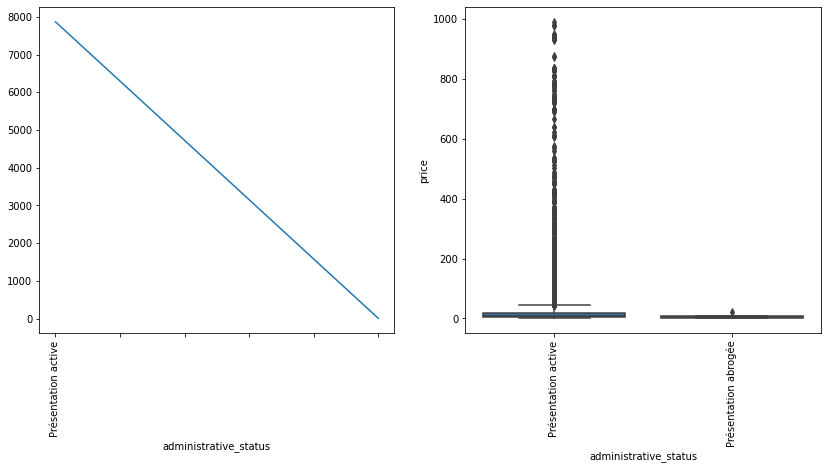

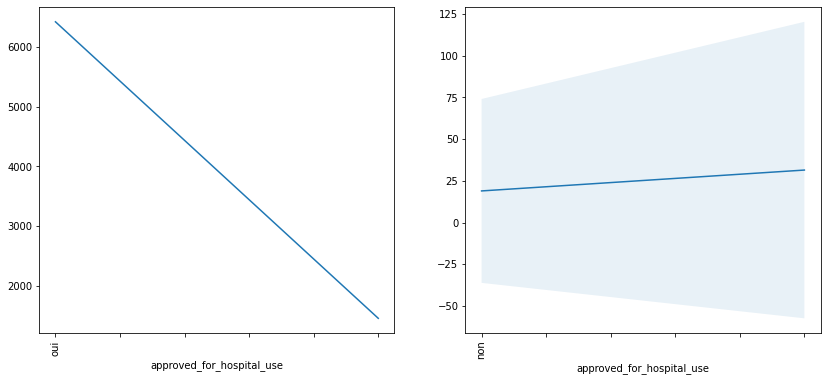

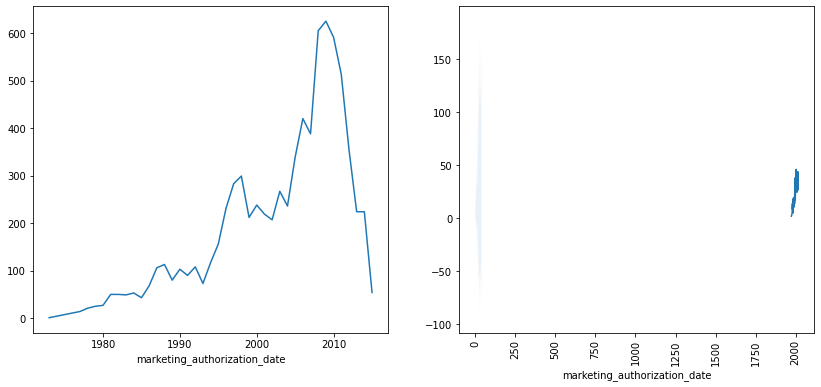

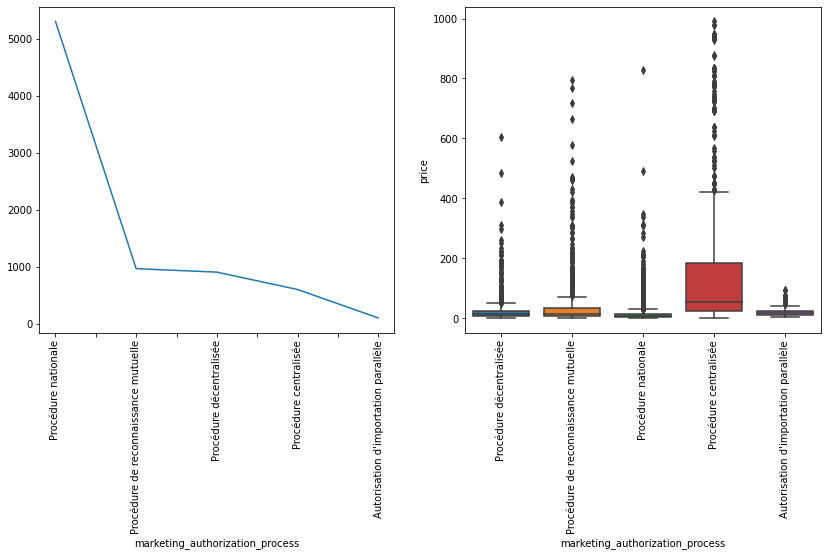

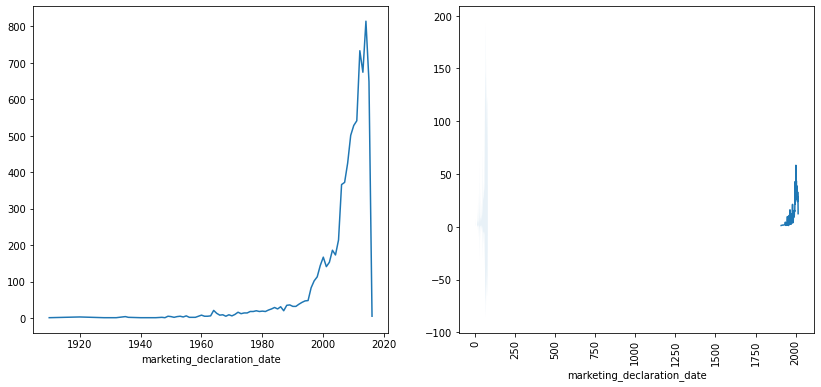

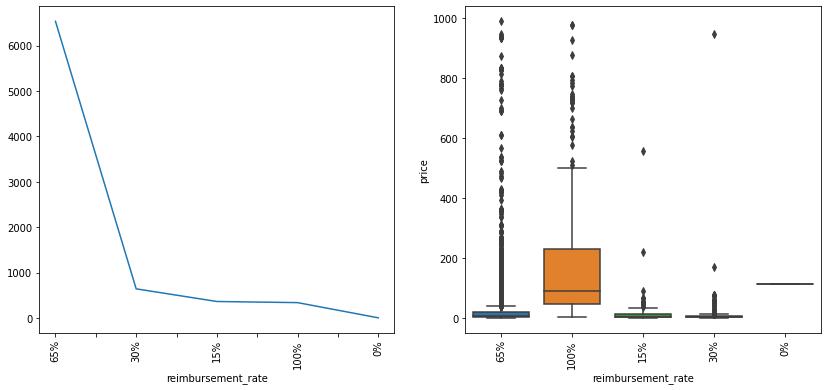

In [16]:
#i=1
for col in  df_train.columns.difference([col for col in df_train.columns if 'label_' in col or 'count_' in col]):
    if col not in ['description', 'pharmaceutical_companies' ,'price'] :
#       plt.subplot(i,1,i)
        plot_features(df_train, col)
#       i = i+1

### Encoding categorical data into numerical value, i.e.  mean price value for the corresponding category 

In [17]:
def encode_categories(df, col):
    cat_dict = {}
    cats = df[col].astype(dtype = 'category').cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = df[df[col] == cat]['price'].mean()
    df[col] = df[col].map(cat_dict)
    return df

In [18]:
df_train.columns

Index(['description', 'administrative_status', 'approved_for_hospital_use',
       'reimbursement_rate', 'marketing_declaration_date',
       'marketing_authorization_date', 'marketing_authorization_process',
       'pharmaceutical_companies', 'price', 'label_plaquette', 'label_ampoule',
       'label_flacon', 'label_tube', 'label_stylo', 'label_seringue',
       'label_pilulier', 'label_sachet', 'label_comprime', 'label_gelule',
       'label_film', 'label_poche', 'label_capsule', 'count_plaquette',
       'count_ampoule', 'count_flacon', 'count_tube', 'count_stylo',
       'count_seringue', 'count_pilulier', 'count_sachet', 'count_comprime',
       'count_gelule', 'count_film', 'count_poche', 'count_capsule',
       'count_ml'],
      dtype='object')

In [19]:
df_train.groupby(df_train['pharmaceutical_companies'])['price'].aggregate('mean').to_dict()

{'ABBOTT PRODUCT': 8.379666666666667,
 'ABBVIE (ROYAUME-UNI': 486.0083333333334,
 'ABDI FARMA (PORTUGAL': 14.520000000000001,
 'ACCORD HEALTHCARE (ROYAUME UNI': 31.440606060606058,
 'ACCORD HEALTHCARE FRANC': 14.362,
 'ACINO PHARMA (ALLEMAGNE': 16.93,
 'ACRA': 2.04,
 'ACTAVIS FRANC': 6.944864864864864,
 'ACTAVIS GROUP (ISLANDE': 7.273333333333333,
 'ACTAVIS GROUP PTC (ISLANDE': 17.36703703703704,
 'ADDMEDIC': 83.61,
 'ADVICENN': 70.5,
 'AEROCI': 2.95,
 'AGFA HEALTHCARE IMAGING AGENTS (ALLEMAGNE': 40.23166666666666,
 'AGUETTAN': 27.231428571428573,
 'ALCO': 2.7976470588235296,
 'ALCON LABORATORIES (ROYAUME-UNI': 12.461666666666666,
 'ALFA WASSERMANN PHARM': 7.1659999999999995,
 'ALK ABELLO (DANEMARK': 35.19,
 'ALKOPHARMA (LUXEMBOURG': 2.1375,
 'ALLERGAN FRANC': 4.523333333333333,
 'ALLERGAN PHARMACEUTICALS IRELAND (IRLANDE': 15.907142857142857,
 'ALLIANCE PHARMACEUTICALS (ROYAUME-UNI': 14.125,
 'ALMIRAL': 9.705555555555556,
 'ALMIRALL (ESPAGNE': 3.372,
 'AMBAPHAR': 21.27,
 'AMDIPHAR': 4

In [20]:
df_encoded_train = df_train.copy()
for col in df_encoded_train.select_dtypes(['object']).columns:
    encode_categories(df_encoded_train, col)

In [21]:
df_encoded_train.describe()

description  administrative_status  approved_for_hospital_use  \
count  7877.000000            7877.000000                7877.000000   
mean     29.159704              29.159704                  29.159704   
std      76.906817               0.784511                   4.863629   
min       0.750000               7.157000                  18.972442   
25%       6.074726              29.187673                  31.481415   
50%      11.788374              29.187673                  31.481415   
75%      20.315000              29.187673                  31.481415   
max     990.390000              29.187673                  31.481415   

       reimbursement_rate  marketing_declaration_date  \
count         7877.000000                 7877.000000   
mean            29.159704                 2006.215691   
std             31.571451                   10.682919   
min              8.185000                 1910.000000   
25%             24.513646                 2004.000000   
50%             24.513646                 2010.000000   
75%             24.513646                 2013.000000   
max            176.807887                 2016.000000   

       marketing_authorization_date  marketing_authorization_process  \
count                   7877.000000                      7877.000000   
mean                    2003.116288                        29.159704   
std                        8.293281                        38.454958   
min                     1973.000000                        13.251095   
25%                     1998.000000                        13.251095   
50%                     2006.000000                        13.251095   
75%                     2009.000000                        25.333547   
max                     2015.000000                       159.438233   

       pharmaceutical_companies        price  label_plaquette  ...  \
count               7877.000000  7877.000000      7877.000000  ...   
mean                  29.159704    29.159704         0.688714  ...   
std                   56.030031    83.803032         0.463049  ...   
min                    0.990000     0.600000         0.000000  ...   
25%                   12.320131     3.770000         0.000000  ...   
50%                   13.338750     7.730000         1.000000  ...   
75%                   18.279057    19.770000         1.000000  ...   
max                  948.280000   990.390000         1.000000  ...   

       count_stylo  count_seringue  count_pilulier  count_sachet  \
count  7877.000000     7877.000000     7877.000000   7877.000000   
mean      0.002666        0.102323        0.006094      0.478355   
std       0.075541        0.842733        0.113638      4.011625   
min       0.000000        0.000000        0.000000      0.000000   
25%       0.000000        0.000000        0.000000      0.000000   
50%       0.000000        0.000000        0.000000      0.000000   
75%       0.000000        0.000000        0.000000      0.000000   
max       5.000000       28.000000        3.000000    120.000000   

       count_comprime  count_gelule   count_film  count_poche  count_capsule  \
count     7877.000000   7877.000000  7877.000000  7877.000000    7877.000000   
mean        25.200457      4.807795     0.001904     0.046718       0.256189   
std         33.302857     16.981553     0.049079     0.899524       3.885928   
min          0.000000      0.000000     0.000000     0.000000       0.000000   
25%          0.000000      0.000000     0.000000     0.000000       0.000000   
50%         15.000000      0.000000     0.000000     0.000000       0.000000   
75%         30.000000      0.000000     0.000000     0.000000       0.000000   
max        480.000000    360.000000     2.000000    40.000000     120.000000   

          count_ml  
count  7877.000000  
mean     14.079588  
std     100.419077  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max    2400.000000  

[8 rows x 36 columns]

#### Correlation visualization among different column and in regards to drug price as well

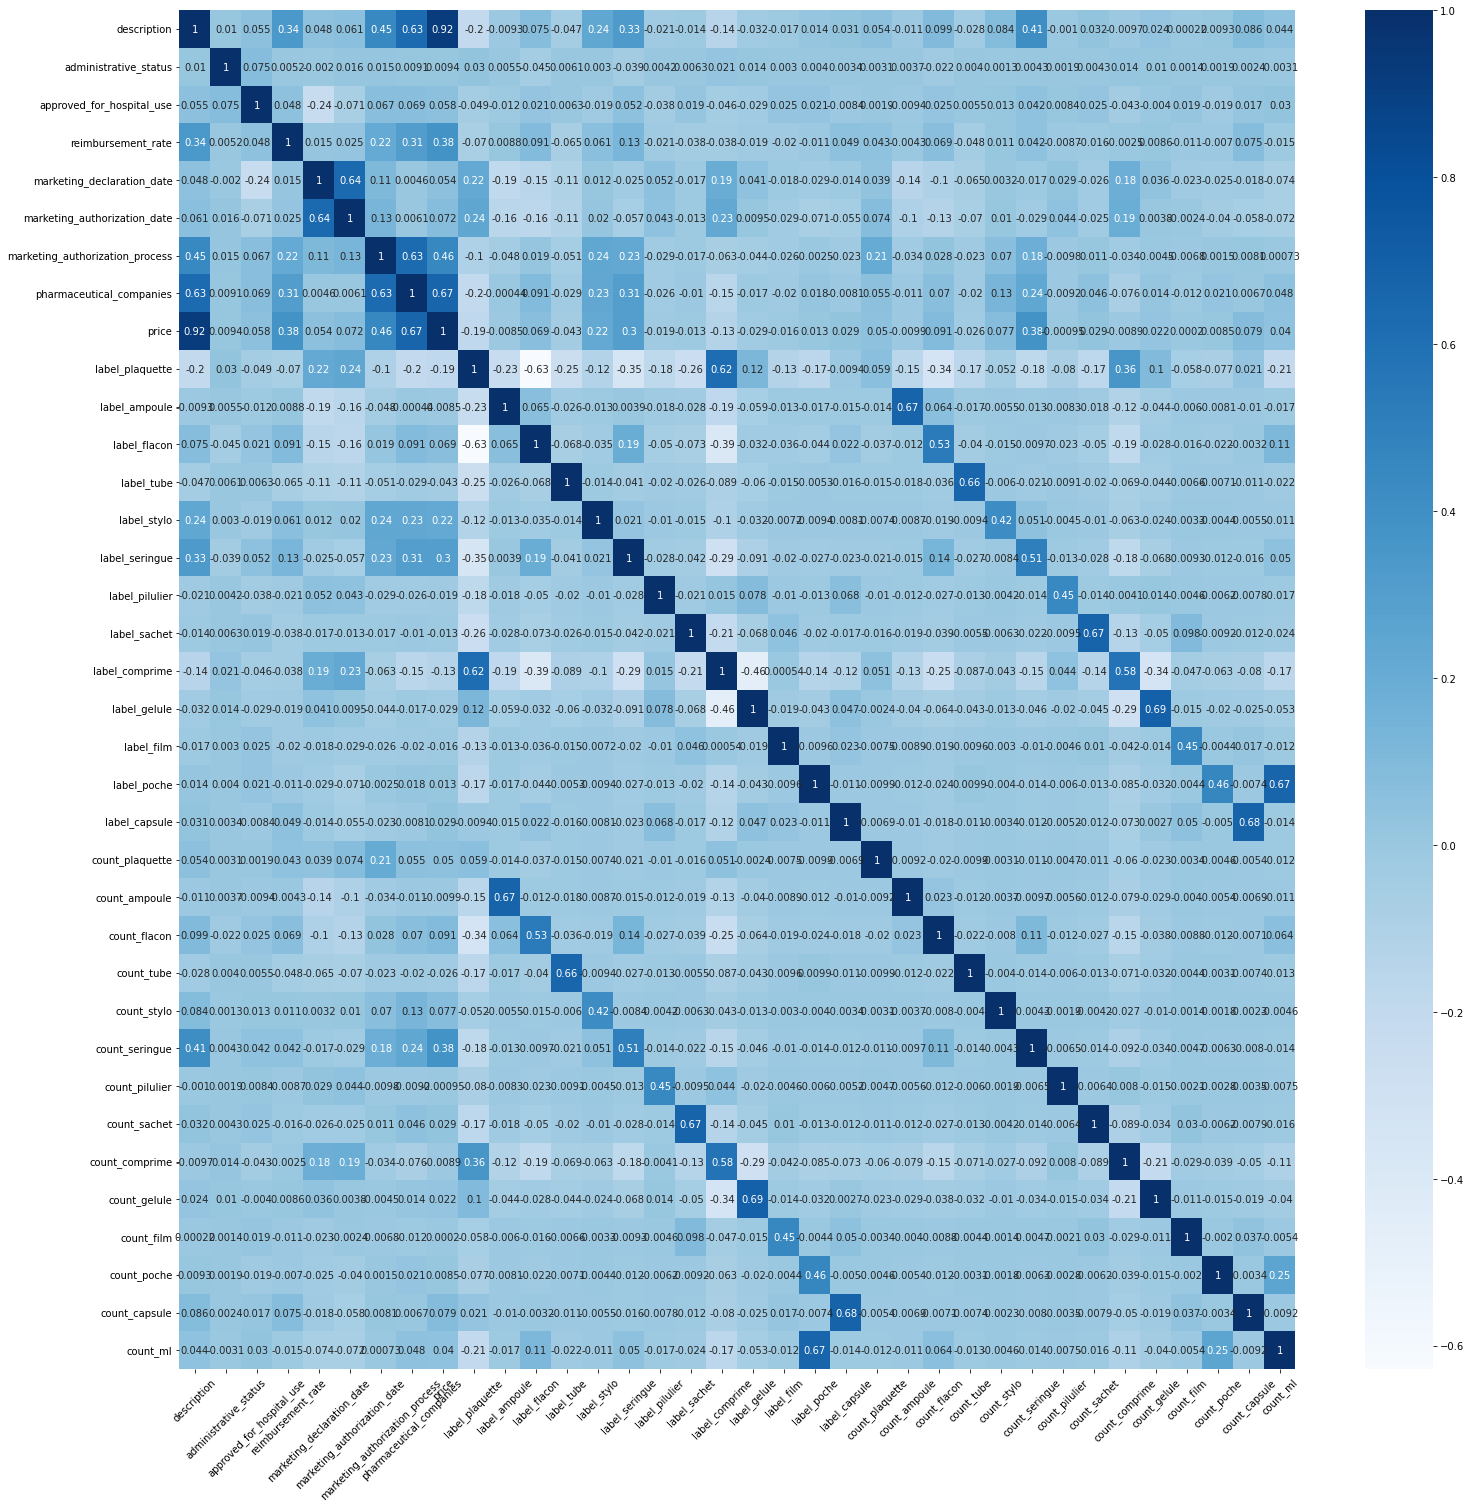

In [22]:
# Correlation is always a good indicator of the relationship between two variables.And here we can see the correlation between the features
# Selecting all the columns in the train dataframe except the UserID column and then calculating the
# correlation between them.
plt.figure(figsize=(25,25))
features = df_encoded_train.columns
sns.heatmap(df_encoded_train[features].corr(), cmap = 'Blues', annot = True)
plt.xticks(rotation = 45)
plt.show()

### An Outlier Study

In [23]:
#Outlier detection study #IQR method
stat = df_train['price'].describe()
#print(stat)
IQR = stat['75%'] - stat['25%']
upper = stat ['75%'] + 1.5 * IQR
lower = stat ['25%'] - 1.5 * IQR
print('IQR method: The upper and lower bound as suspected outliers are  {} & {}' . format(upper, lower))

#Outlier detection # Mean Absoluet devitation
stat = df_train['price'].describe()
upper = stat ['mean'] + 3* stat ['std']
lower = stat ['mean'] - 3 * stat ['std']
print('Mean Absoluet devitation: The upper and lower bound as suspected outliers are  {} & {}' . format(upper, lower))

#Outlier detection # MEdian Absoluet devitation
stat = df_train['price'].describe()
median = df_train['price'].median()
upper = median + 3* stat ['std']
lower = median - 3 * stat ['std']
print('Median Absoluet devitation: The upper and lower bound as suspected outliers are  {} & {}' . format(upper, lower))

#outlier data
df_train[~((df_train['price'] >= lower) & (df_train['price'] <= upper))].reset_index(drop=True)

np.where(df_train['price'] >= upper,
        upper,
        np.where(df_train['price'] <= lower,
        df_train['price'].min(),
        df_train['price']))

#Outlier detection # Quantile method
upper_limit = df_train['price'].quantile(0.99)
lower_limit = df_train['price'].quantile(0.01)

print('Quantile method: The upper and lower bound as suspected outliers are  {} & {}' . format(upper_limit, lower_limit))
#outlier data
df_train[~((df_train['price'] >= lower_limit) & (df_train['price'] <= upper_limit))].reset_index(drop=True)
# Winsorization
np.where(df_train['price'] >= upper_limit,
        upper_limit,
        np.where(df_train['price'] <= lower_limit,
        lower_limit,
        df_train['price']))

IQR method: The upper and lower bound as suspected outliers are  43.769999999999996 & -20.23
Mean Absoluet devitation: The upper and lower bound as suspected outliers are  280.5688007780864 & -222.24939237387156
Median Absoluet devitation: The upper and lower bound as suspected outliers are  259.139096575979 & -243.679096575979
Quantile method: The upper and lower bound as suspected outliers are  452.12239999999997 & 1.08


array([  2.83  ,  14.3   ,   5.66  , ..., 452.1224,   3.94  ,  14.21  ])

## Feature Engineering and Encoding

In [24]:
df_train_features = df_train.copy()

In [25]:
def authorization_period(df):
    #df['authorization_processing_period'] = (df['marketing_declaration_date'] - df['marketing_authorization_date']) 
    # # Error in this feature as we have some cases where authorization date is greater than marketing and in some vice-versa
    return df

In [26]:
def dirty_categories(df):
        """
        The function takes in a dataframe and returns a dataframe with the rare labels encoded for dirt category columns
        the column in this case is pharmaceutical_companies
        the transformer encodes the categories with low value count into Rare/low_val category
        and the rest remain the same
        :return: The learning object for test data and the dataframe
        """
        df = df[[col for col in df.columns if 'price' not in col]]
        categorical_transformer_dirty = RareLabelEncoder(tol=0.0005, n_categories=25, max_n_categories=None, replace_with='Low_count', variables='pharmaceutical_companies', ignore_format=False)
        learning = categorical_transformer_dirty.fit(df)
        df = learning.transform(df)
        return learning, df

def dirty_categories_alt(df):
        learning_companies = df.groupby(df['pharmaceutical_companies'])['price'].aggregate('mean').to_dict()
        null_company_val = df['price'].mean()
        df['pharmaceutical_companies'] = df['pharmaceutical_companies'].map(learning_companies)


        learning_description = df.groupby(df['description'])['price'].aggregate('mean').to_dict()
        null_desc_val = df['price'].median()
        df['description'] = df['description'].map(learning_description)
        return learning_companies, null_company_val, learning_description, null_desc_val, df

In [27]:
def feature_engineering(df):
        """
        The function takes in a dataframe and returns a list of three objects: a learning object, a
        transformer object and a matrix of the transformed data
        :return: The learning object is the transformer object, which is the ColumnTransformer object.
        The transformed data and the transformer as well.
        """
        #This particular try except block is to handle the error that arises when the dataframe doesnot contain the predicted label price
        try: 
            df =  df[[col for col in  df.columns if 'price' not in col]]
        except:
            pass

        ordinal_encoder_features = ['label_plaquette', 'label_ampoule', 'label_flacon', 'label_tube', 'label_stylo', 'label_seringue', 'label_pilulier', 'label_sachet', 'label_comprime', 'label_gelule', 'label_film', 'label_poche', 'label_capsule']
        OE_transformer = OrdinalEncoder(categories = 'auto' )

        binning_features = ['marketing_declaration_date'] #+ ['authorization_processing_period']
        KBinsDiscretizer_transformer = KBinsDiscretizer(n_bins=15, encode='onehot', strategy='kmeans', random_state=42)

        binning_features_1 = ['marketing_authorization_date'] +['pharmaceutical_companies'] + ['description'] #+ ['authorization_processing_period']
        KBinsDiscretizer_transformer_1 = KBinsDiscretizer(n_bins=15, encode='onehot', strategy='kmeans', random_state=42)

        categorical_features = ['administrative_status','approved_for_hospital_use', 'reimbursement_rate','marketing_authorization_process']
        OHE_transformer = OneHotEncoder(sparse=False,   handle_unknown='error')

        transformer = ColumnTransformer(transformers = [("OE", OE_transformer, ordinal_encoder_features),
                                                    ("KBin", KBinsDiscretizer_transformer, binning_features),
                                                    ("KBin1", KBinsDiscretizer_transformer_1, binning_features_1),
                                                    ("OHE", OHE_transformer, categorical_features)])
        
        learning = transformer.fit(df)
        ml = transformer.transform(df)
        #print(feature.get_feature_names())

        return learning, transformer, ml
        

In [28]:
# Aquick separation of variables and target predictor
#Y_train = df_train_features['price'] # Split the Label or dependent variable from the dataframe
#df_train_features = df_train_features.drop(['price'], axis=1)

df_train_features = authorization_period(df_train_features)
dirty_learn_company, na_val_comp, dirty_learn_desc, na_learn_desc, df_train_features = dirty_categories_alt(df_train_features)




encodings_learned, transformer, df_train_encoded = feature_engineering(df_train_features)

cols = transformer.get_feature_names_out()
ml_train = pd.DataFrame(df_train_encoded,columns=cols)    
dropper = ['label_plaquette', 'label_ampoule', 'label_flacon', 'label_tube', 'label_stylo', 'label_seringue', 'label_pilulier', 'label_sachet', 'label_comprime', 'label_gelule', 'label_film', 'label_poche', 'label_capsule'] + ['marketing_declaration_date', 'marketing_authorization_date'] + ['administrative_status','approved_for_hospital_use', 'reimbursement_rate','marketing_authorization_process','pharmaceutical_companies'] # + ['authorization_processing_period']
df_train_features = df_train_features.drop(dropper, axis=1)
df_train_features = pd.concat([df_train_features ,ml_train], axis = 1)
#Finally dataframe is ready for ML modeling
#Merging the Y label with rest of the Dataframe



Y_train = df_train_features['price'] # Split the Label or dependent variable from the dataframe
df_train_features = df_train_features.drop(['price'], axis=1)

df_train_features = pd.merge(df_train_features, pd.Series(Y_train), left_index=True, right_index=True)

In [29]:
## LETS Prepare the test data as well
df_test = fix_duplicates(df_test_data)
df_test = date_features(df_test)
df_test = fix_missing_label_count(df_test,df_features)

df_test_feature =  authorization_period(df_test)
#df_test_feature = dirty_learn.transform(df_test_feature)

df_test_feature['pharmaceutical_companies'] = df_test_feature['pharmaceutical_companies'].map(dirty_learn_company)
df_test_feature['pharmaceutical_companies'] = df_test_feature['pharmaceutical_companies'].fillna(na_val_comp)
df_test_feature['description'] = df_test_feature['description'].map(dirty_learn_desc)
df_test_feature['description'] = df_test_feature['description'].fillna(na_learn_desc)

df_test_encoded = encodings_learned.transform(df_test_feature)

ml_test = pd.DataFrame(df_test_encoded,columns=cols)    
df_test_feature = df_test.drop(dropper, axis=1)
df_test_feature = pd.concat([df_test_feature ,ml_test], axis = 1)

In [30]:
print(df_train_features.shape)
print(df_test_feature.shape)

(7877, 103)
(3306, 102)


## Model building, validating, hyperparameter tuning

In [31]:
# Train - Test Split
X,Y = df_train_features.drop(['description','price'],axis=1),df_train_features['price']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [32]:
# Adjusted R2 Score as an evaluation metric
def adj_r2(estimator, X, y_true):
    n, p = X.shape
    pred = estimator.predict(X)
    return 1 - ((1 - r2_score(y_true, pred)) * (n - 1))/(n-p-1)

### Model 1: Gradient Boosting

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

reg_gb = GradientBoostingRegressor(random_state=0)
reg_gb.fit(X_train, y_train)

y_pred = reg_gb.predict(X_test)

adjusted_r2_gb = 1 - ( 1-reg_gb.score(X_test, y_test) ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test.shape[1] - 1 )
print("Adjusted R2 score: {:.2f}  " .format(adjusted_r2_gb))

Adjusted R2 score: 0.82  


In [34]:
from sklearn.model_selection import cross_val_score
regress_gb = GradientBoostingRegressor(random_state=0)
scores_gb = cross_val_score(regress_gb, X, Y, scoring=adj_r2, cv=5, n_jobs=-1)
print("model scores:{}".format(scores_gb))
print("The R2 score of the model on the training data is: %0.2f (+/- %0.2f)" % (scores_gb.mean(), scores_gb.std() * 2)) 

model scores:[0.79681768 0.80321821 0.82319242 0.79633605 0.83022967]
The R2 score of the model on the training data is: 0.81 (+/- 0.03)


In [35]:
from scipy.stats import loguniform

param_grid_gb = {
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": [0.01, 0.1, 0.2, 0.5,1],
}
    

gb_grid = GridSearchCV( estimator = GradientBoostingRegressor(), 
                        param_grid = param_grid_gb,
                        scoring=adj_r2,
                        cv=5, 
                        n_jobs=-1,
                        verbose = 10)

grid_result_gb = gb_grid.fit(X, Y)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV 4/5; 1/270] START learning_rate=0.01, max_leaf_nodes=2, n_estimators=1......
[CV 1/5; 2/270] START learning_rate=0.01, max_leaf_nodes=2, n_estimators=2......
[CV 5/5; 1/270] START learning_rate=0.01, max_leaf_nodes=2, n_estimators=1......
[CV 3/5; 2/270] START learning_rate=0.01, max_leaf_nodes=2, n_estimators=2......
[CV 2/5; 2/270] START learning_rate=0.01, max_leaf_nodes=2, n_estimators=2......
[CV 4/5; 1/270] END learning_rate=0.01, max_leaf_nodes=2, n_estimators=1;, score=-0.066 total time=   0.0s
[CV 3/5; 2/270] END learning_rate=0.01, max_leaf_nodes=2, n_estimators=2;, score=-0.060 total time=   0.1s
[CV 5/5; 1/270] END learning_rate=0.01, max_leaf_nodes=2, n_estimators=1;, score=-0.064 total time=   0.1s
[CV 1/5; 2/270] END learning_rate=0.01, max_leaf_nodes=2, n_estimators=2;, score=-0.059 total time=   0.1s
[CV 1/5; 3/270] START learning_rate=0.01, max_leaf_nodes=2, n_estimators=5......
[CV 2/5; 2/270] END le

In [36]:
print('Best Score: ', grid_result_gb.best_score_)
print('Best Params: ', grid_result_gb.best_params_)

Best Score:  0.8311678226728414
Best Params:  {'learning_rate': 1, 'max_leaf_nodes': 2, 'n_estimators': 50}


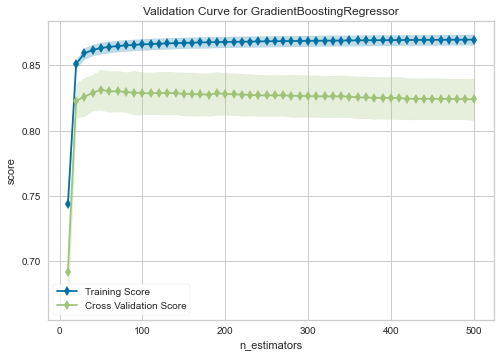

<AxesSubplot:title={'center':'Validation Curve for GradientBoostingRegressor'}, xlabel='n_estimators', ylabel='score'>

In [37]:
from yellowbrick.datasets import load_energy
from yellowbrick.model_selection import ValidationCurve

viz_gb = ValidationCurve(
    GradientBoostingRegressor(learning_rate= grid_result_gb.best_params_['learning_rate'], 
                                max_leaf_nodes= grid_result_gb.best_params_['max_leaf_nodes']), 
                                param_name="n_estimators",
                                param_range=np.arange(10, 510, 10), 
                                cv=5, 
                                scoring=adj_r2
)

# Fit and show the visualizer
viz_gb.fit(X, Y)
viz_gb.show()

### Model 2: Random Forest

In [38]:
rf_reg_model =  RandomForestRegressor(bootstrap= True, max_features= None , n_estimators= 105, n_jobs=-1, random_state=111)
rf_reg_model.fit(X_train, y_train)
y_pred = rf_reg_model.predict(X_test)
adjusted_r2_rf = 1 - ( 1- rf_reg_model.score(X_test, y_test) ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test.shape[1] - 1 )
print("Adjusted R2 score: {:.2f}  " .format(adjusted_r2_rf))

Adjusted R2 score: 0.78  


In [39]:
from sklearn.model_selection import cross_val_score
regress = RandomForestRegressor(bootstrap= True, max_features= None, n_estimators= 300, random_state=111)
scores = cross_val_score(regress, X, Y, scoring=adj_r2, cv=5, n_jobs=-1)
print("model scores:{}".format(scores))
print("The Adjusted R2 score of the model on the training data is: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)) 

model scores:[0.78694095 0.7961983  0.78529952 0.76895839 0.75123853]
The Adjusted R2 score of the model on the training data is: 0.78 (+/- 0.03)


In [40]:
# Hyperparameter tuning
n_estimators = n_estimators = [40,50,60,70,80,90,100] # number of trees in the random forest
max_features = ['sqrt','log2',None] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points


rf_class = RandomForestRegressor()

param_grid = dict(n_estimators=n_estimators,
                max_features=max_features,
                max_depth= max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf
                )

rf_grid = GridSearchCV(estimator=rf_class,
                    param_grid=param_grid,
                    scoring=adj_r2,
                    cv=5,
                    verbose=10,
                    n_jobs=-1)
grid_result = rf_grid.fit(X, Y)

Fitting 5 folds for each of 2268 candidates, totalling 11340 fits
[CV 3/5; 2/2268] START max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 4/5; 1/2268] START max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40
[CV 2/5; 1/2268] START max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40
[CV 5/5; 2/2268] START max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 1/5; 3/2268] START max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60
[CV 4/5; 1/2268] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40;, score=0.637 total time=   0.4s
[CV 2/5; 1/2268] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40;, score=0.680 total time=   0.4s
[CV 3/5; 3/2268] START max_depth=10, max_features=sqrt, min_samples_leaf=1, min_s

In [41]:
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.8055916407675735
Best Params:  {'max_depth': 30, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}


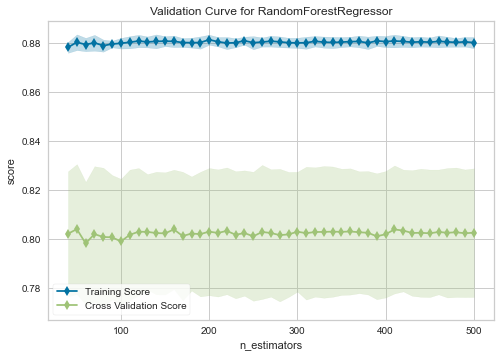

<AxesSubplot:title={'center':'Validation Curve for RandomForestRegressor'}, xlabel='n_estimators', ylabel='score'>

In [44]:
from yellowbrick.datasets import load_energy
from yellowbrick.model_selection import ValidationCurve

viz_rf = ValidationCurve(
    RandomForestRegressor(max_features=None,
                            max_depth= grid_result.best_params_['max_depth'],
                            min_samples_split=grid_result.best_params_['min_samples_split'],
                            min_samples_leaf=grid_result.best_params_['min_samples_leaf']
                            ), param_name="n_estimators",
    param_range=np.arange(40, 510, 10), cv=5, scoring=adj_r2
)

# Fit and show the visualizer
viz_rf.fit(X, Y)
viz_rf.show()

## Evaluation of model performance and results

In [45]:
history_gb = grid_result_gb.cv_results_ # Aceessing the results of the grid search
history_gb['params'] # Parameters of our grid search experiment
history_gb['mean_test_score'] # Mean score of each parameter combination

hi_plot_gb =[]
for i in range(len(history_gb['params'])):
    t = history_gb['params'][i]
    t['mean_adjusted_R2'] = history_gb['mean_test_score'][i].round(3)*100
    hi_plot_gb.append(t)

In [48]:
hip.Experiment.from_iterable(hi_plot_gb).display(force_full_width=True)

<IPython.core.display.Javascript object>

In [49]:
history_rf = grid_result.cv_results_ # Aceessing the results of the grid search
history_rf['params'] # Parameters of our grid search experiment
history_rf['mean_test_score'] # Mean score of each parameter combination

hi_plot =[]
for i in range(len(history_rf['params'])):
    t = history_rf['params'][i]
    t['mean_adjusted_R2'] = history_rf['mean_test_score'][i].round(3)*100
    hi_plot.append(t)

In [50]:
# This is a way to visualize the results of the hyperparameter tuning.
hip.Experiment.from_iterable(hi_plot).display(force_full_width=True)
# We import hiplot library to visualiza the interaction and relationship between differnt parameters and the accuracy for every combination run

<IPython.core.display.Javascript object>

#### Final model

In [60]:
final_model =  GradientBoostingRegressor(random_state=111, learning_rate = 1, max_leaf_nodes = 2, n_estimators = 50)

final_model.fit(X_train, y_train)
y_final_pred = final_model.predict(X_test)
adjusted_r2_final = 1 - ( 1- final_model.score(X_test, y_test) ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test.shape[1] - 1 )
print("Adjusted R2 score: {:.2f}  " .format(adjusted_r2_final))

Adjusted R2 score: 0.84  


In [61]:
feature_importance = pd.concat([pd.Series(final_model.feature_names_in_),pd.Series(final_model.feature_importances_)], axis = 1)
feature_importance.columns = ['feature_name', 'feature_importance']
feature_importance.sort_values(by = 'feature_importance', ascending = False).reset_index(drop = True).head(10)

feature_name  feature_importance
0        KBin1__description_0.0            0.259419
1       KBin1__description_14.0            0.124725
2        KBin1__description_1.0            0.113100
3       KBin1__description_12.0            0.104984
4       KBin1__description_11.0            0.079963
5        KBin1__description_9.0            0.072625
6  OHE__reimbursement_rate_100%            0.057649
7        KBin1__description_8.0            0.035659
8       KBin1__description_13.0            0.025693
9       KBin1__description_10.0            0.020141

### Additional Reserch, part of recommendations

In [36]:
#FEATURE SELCTION METHODOLOGY
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_label = X[list(X.columns)]

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X_label.values, i) for i in range(X_label.shape[1])]
vif_info['Column'] = X_label.columns
vif_info.sort_values('VIF', ascending=False)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF                                          Column
54        inf         KBin__marketing_authorization_date_12.0
27        inf            KBin__marketing_declaration_date_0.0
29        inf            KBin__marketing_declaration_date_2.0
30        inf            KBin__marketing_declaration_date_3.0
31        inf            KBin__marketing_declaration_date_4.0
..        ...                                             ...
184  1.153315      OHE__pharmaceutical_companies_NORDIC PHARM
218  1.150458     OHE__pharmaceutical_companies_SANOFI PASTEU
212  1.147093      OHE__pharmaceutical_companies_SAINT GERMAI
118  1.146405               OHE__pharmaceutical_companies_DEX
57   1.035371  OHE__administrative_status_Présentation active

[245 rows x 2 columns]

In [37]:
vif_info[vif_info['VIF']<5].sort_values('VIF', ascending=False)

VIF                                          Column
141  4.568109    OHE__pharmaceutical_companies_GLAXOSMITHKLIN
25   4.321540                                 OE__label_poche
152  3.991600    OHE__pharmaceutical_companies_KRKA (SLOVENIE
188  3.828378    OHE__pharmaceutical_companies_NOVARTIS PHARM
23   3.500779                                OE__label_gelule
..        ...                                             ...
184  1.153315      OHE__pharmaceutical_companies_NORDIC PHARM
218  1.150458     OHE__pharmaceutical_companies_SANOFI PASTEU
212  1.147093      OHE__pharmaceutical_companies_SAINT GERMAI
118  1.146405               OHE__pharmaceutical_companies_DEX
57   1.035371  OHE__administrative_status_Présentation active

[186 rows x 2 columns]

## Finish